In [2]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


### Loading Data

In [3]:
sr=500

In [4]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [1]:
Y.head(10)

NameError: name 'Y' is not defined

## Data Augmentation

In [6]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

### DA Application

In [7]:

with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

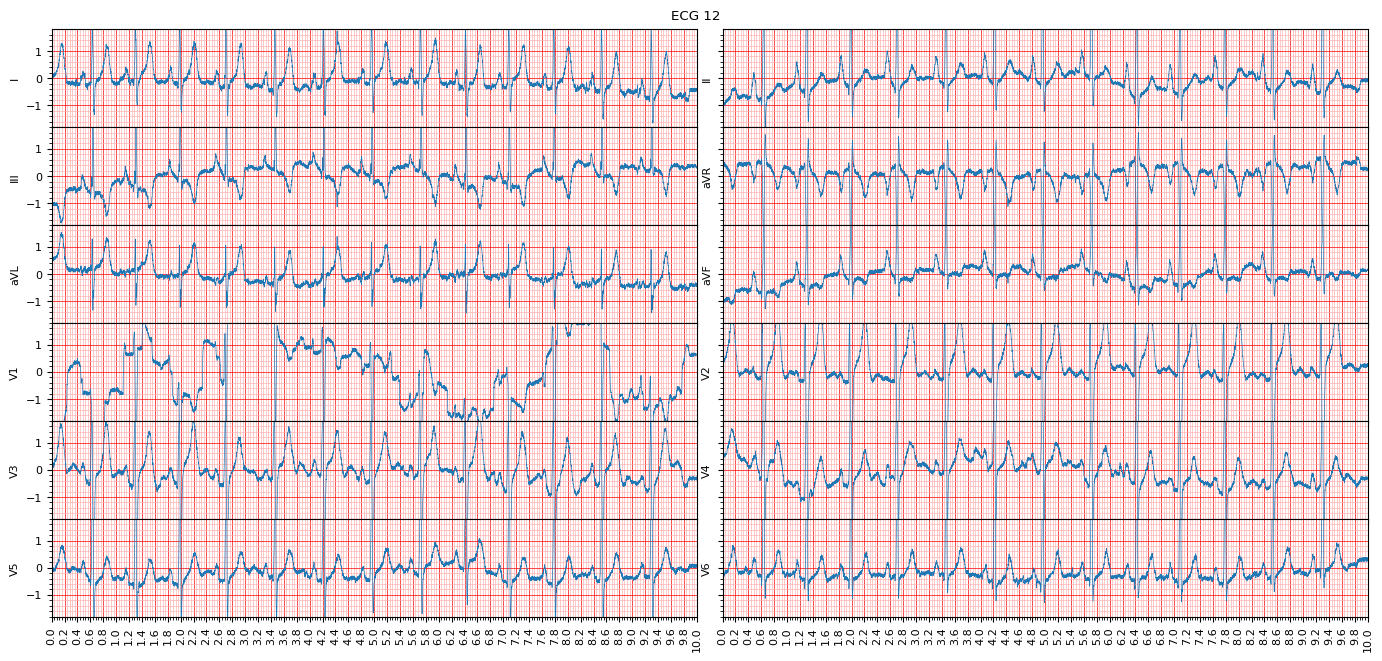

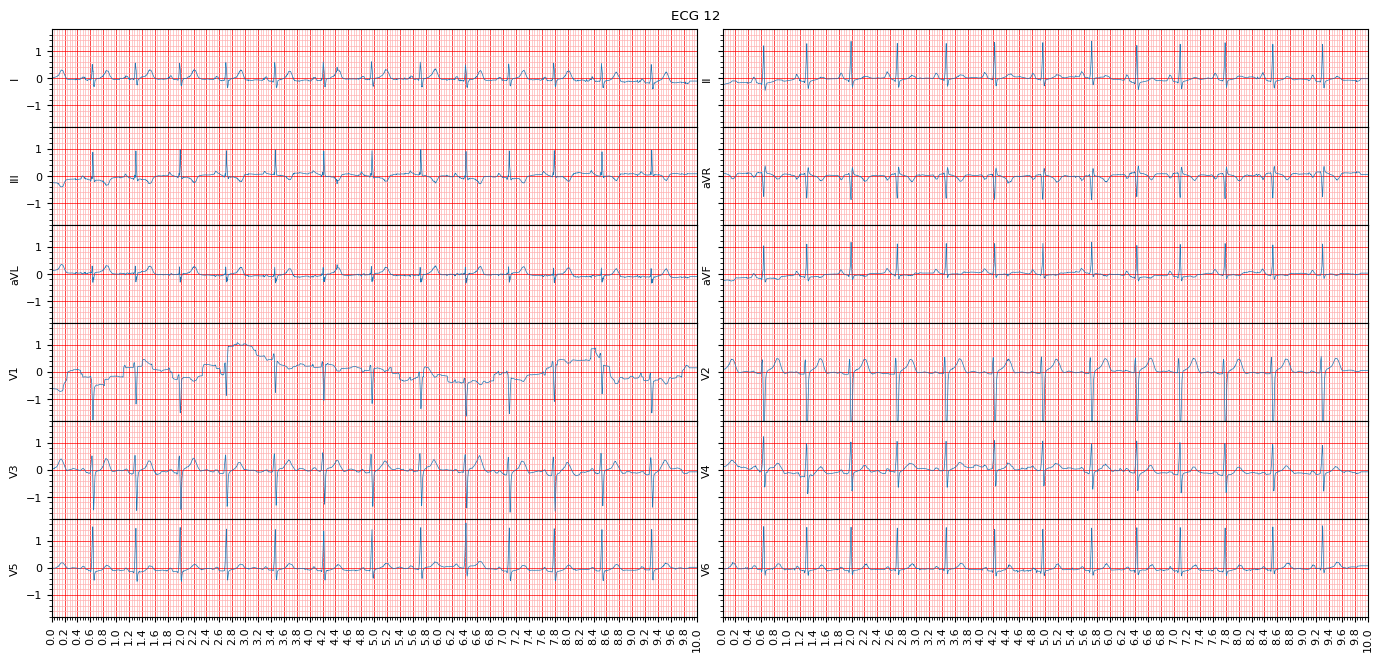

In [8]:
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X_final, (0,2,1))[5], sample_rate=sr)
    ecg_plot.plot_12(tf.transpose(X, (0,2,1))[5], sample_rate=sr)

### Splitting data into Train, Validation, Testing

In [9]:

with tf.device('/CPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].sex

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].sex

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].sex

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return X_train, y_train, X_val, y_val, X_test, y_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 5000, 12), (17418,), (2183, 5000, 12), (2183,), (2198, 5000, 12), (2198,))


## Models

### Model 1

In [10]:
# Creating the model
ecg_sex_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_1.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])


# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



# Fitting the model
#history_4 = ecg_sex_model_1.fit(X_train, y_train, epochs = 15, validation_data = (X_test, y_test))

In [2]:
import tensorflow as tf
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(SaveModelCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs['val_accuracy']  # Change to the appropriate metric
        if accuracy >= self.threshold:
            self.model.save_weights(f'best_model_{epoch + 1}.h5')
            print(f'\nModel saved at epoch {epoch + 1} with accuracy {accuracy:.4f}')

### Model 2

In [12]:
with tf.device('/CPU:0'):
    tf.debugging.disable_traceback_filtering
    # Random Seed
    tf.random.set_seed(13)

    # Batching
    batch_size = 16
    num_epochs = 15
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(X_train))
    dataset = dataset.batch(batch_size)

    # Creating the model
    ecg_sex_model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 3, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),


        tf.keras.layers.Flatten(),


        tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])


    # Compiling the model
    ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                        metrics = ['accuracy'])


    # Learning rate scheduler
    early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)



    # Fitting the model
    history = ecg_sex_model_2.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))

Epoch 1/15
1089/1089 [==============================] - 40s 35ms/step - loss: 5.0889 - accuracy: 0.7019 - val_loss: 1.5614 - val_accuracy: 0.7045
Epoch 2/15
1089/1089 [==============================] - 40s 37ms/step - loss: 1.5264 - accuracy: 0.7523 - val_loss: 1.5796 - val_accuracy: 0.7311
Epoch 3/15
1089/1089 [==============================] - 42s 38ms/step - loss: 1.4980 - accuracy: 0.7683 - val_loss: 1.5286 - val_accuracy: 0.7426
Epoch 4/15
1089/1089 [==============================] - 41s 38ms/step - loss: 1.4697 - accuracy: 0.7831 - val_loss: 1.4510 - val_accuracy: 0.7787
Epoch 5/15
1089/1089 [==============================] - 41s 38ms/step - loss: 1.4104 - accuracy: 0.7901 - val_loss: 1.4244 - val_accuracy: 0.7540
Epoch 6/15
1089/1089 [==============================] - 41s 38ms/step - loss: 1.3626 - accuracy: 0.7943 - val_loss: 1.3231 - val_accuracy: 0.7861
Epoch 7/15
1089/1089 [==============================] - 41s 38ms/step - loss: 1.3506 - accuracy: 0.7989 - val_loss: 1.3555 -

### Model 3

In [ ]:

tf.debugging.disable_traceback_filtering

# Batching
batch_size = 64
num_epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(X_train))
dataset = dataset.batch(batch_size)


# Creating the model
ecg_sex_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_3.compile(loss = tf.keras.losses.mse,
                    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                    metrics = ['mae'])


# Call Backs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)


# Train the model

#ecg_sex_model_3.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))

In [13]:
ecg_sex_model_2.evaluate(X_test, y_test)

69/69 [==============================] - 4s 9ms/step - loss: 1.2535 - accuracy: 0.8025


[1.2535289525985718, 0.8025477528572083]

In [14]:
if(sr == 100):
    ecg_sex_model_2.save("../saved_models/100hz/sex_models/model_1.h5")
elif(sr == 500):
    ecg_sex_model_2.save("../saved_models/500hz/sex_models/model_1.h5")

## Performance

### Visualizing Performance

In [15]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools

figsize = (10, 10)

def make_confusion_matrix(X_test, y_test, classes, model, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    cm = confusion_matrix(y_test, tf.round(y_pred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) 
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=(str(model.name) + " for Confusion Matrix"),
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

69/69 [==============================] - 1s 9ms/step


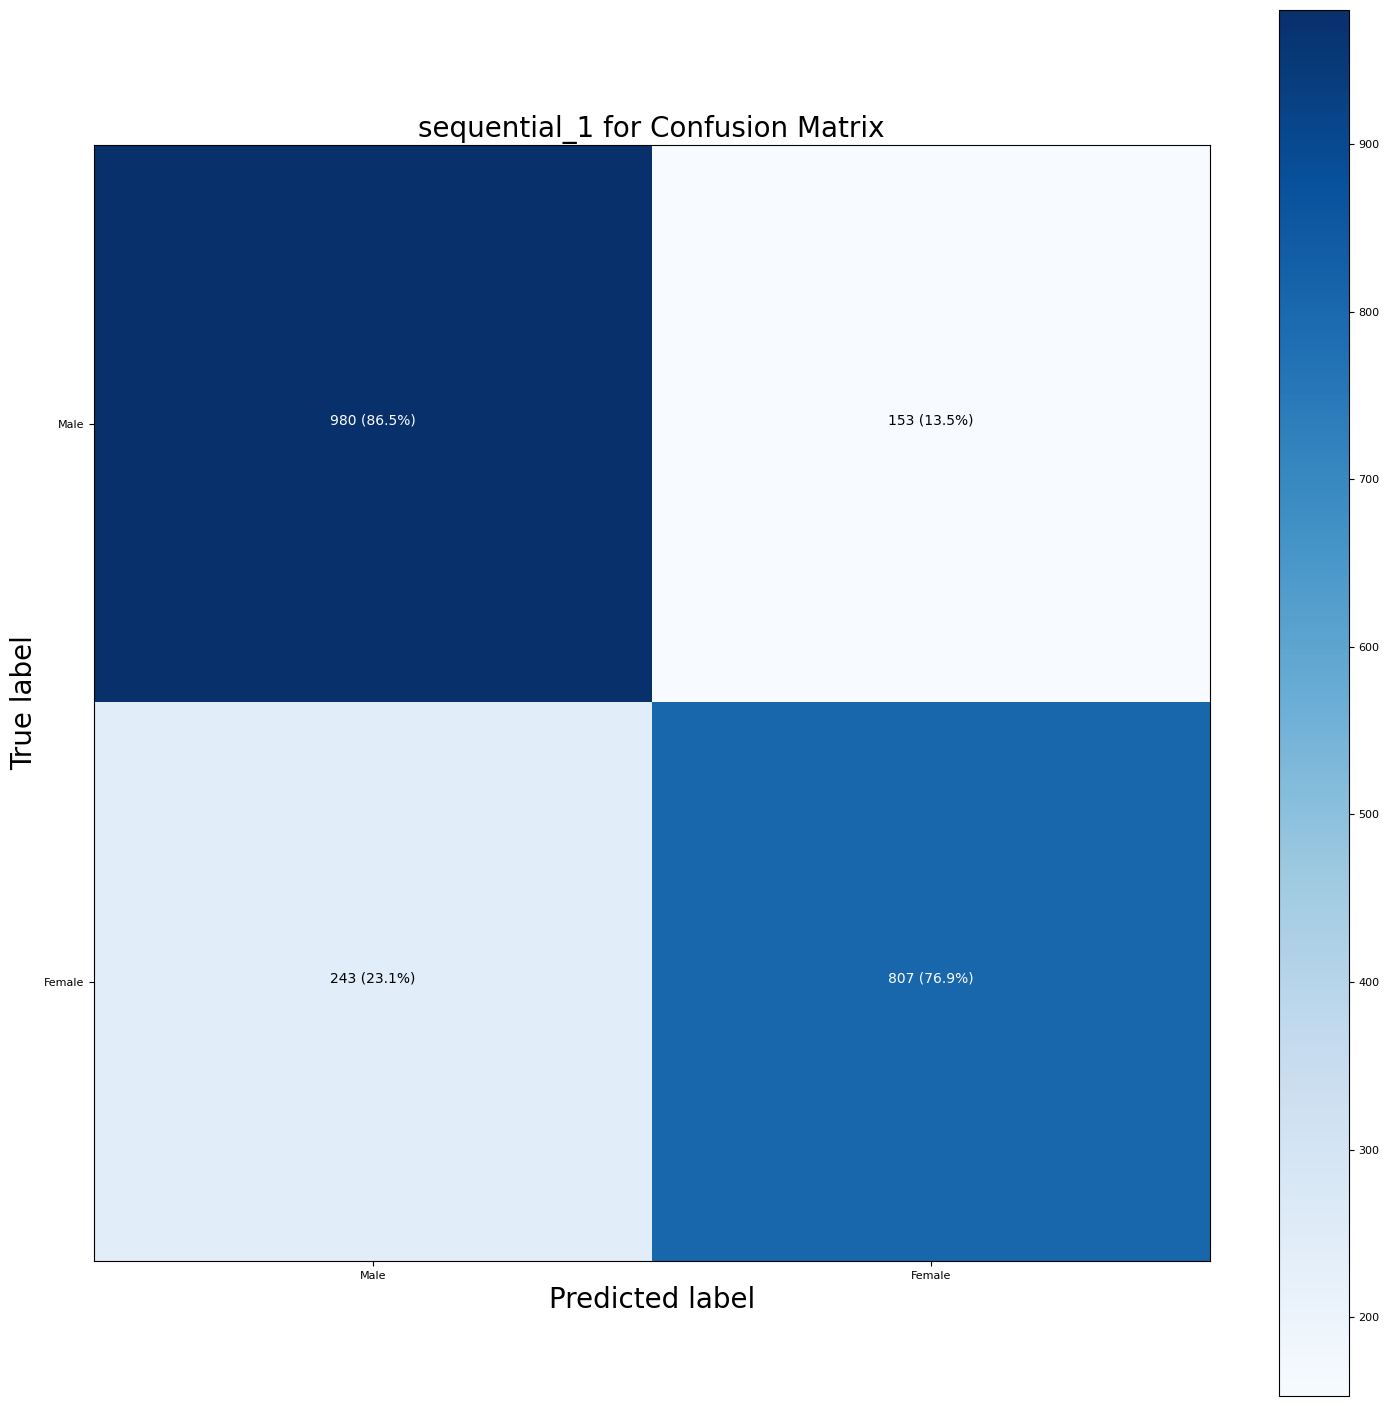

In [16]:
class_name = ['Male', 'Female']
make_confusion_matrix(X_val, y_val, model = ecg_sex_model_2, classes = class_name)

In [17]:
from random import choice

def visualize(y_test, X_test, model):
    class_names  = ['Male', 'Female']
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    for i in range(4):
        ind = choice(range(1, len(X_test)))
        plot_title = ("Actual: " + class_names[y_test[ind]] + "    Predicted: " + class_names[y_pred[ind]])
        ecg_plot.plot_1(tf.transpose(X, (0,2,1))[ind][4], sample_rate=100, title = plot_title + "   aVL focus")

visualize(y_test, X_test, ecg_sex_model_2)

69/69 [==============================] - 0s 7ms/step


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.